****Self-supervised contextual data augmentation for natural language processing (NLP)****

**Problem Statement:** The challenge of effectively augmenting data in Natural Language Processing (NLP) tasks to improve model performance, particularly when data is limited or imbalanced.

**What:** A self-supervised contextual data augmentation method that enhances data with contextual relevance by employing a Label-Masked Language Model (LMLM). This approach helps generate new data that maintains contextual consistency, improving the performance of neural network models for text classification.

**Why:**
The motivation for this method stems from the limitations of existing data augmentation techniques in NLP:

Discrete Nature of Text: Unlike continuous data (e.g., images), text data cannot be easily transformed using basic operations like rotation or scaling.
Contextual Integrity: Simple word replacement with synonyms often fails to preserve the original context, potentially harming model accuracy.


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded 2000 instances from SST2.
Label Distribution: [879, 1121]


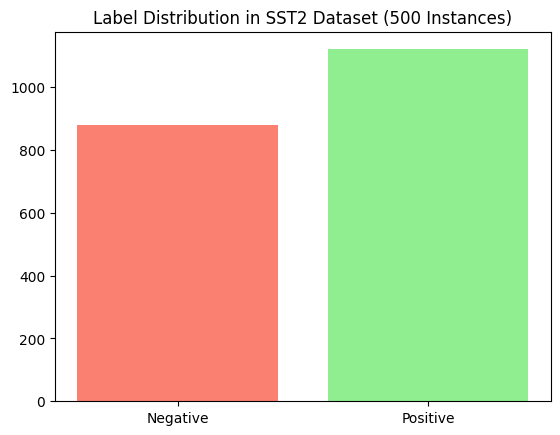

In [ ]:
import torch
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
from transformers import BertTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load the SST2 dataset
from datasets import load_dataset
dataset = load_dataset("glue", "sst2")

# Sample the first 500 instances
train_data = dataset["train"].shuffle(seed=42).select(range(2000))
texts = train_data["sentence"]
labels = train_data["label"]

labels_tensor = torch.tensor(labels).to(device)


print(f"Loaded {len(texts)} instances from SST2.")
print("Label Distribution:", torch.bincount(labels_tensor).tolist())

plt.bar(["Negative", "Positive"], torch.bincount(labels_tensor).tolist(), color=['salmon', 'lightgreen'])
plt.title("Label Distribution in SST2 Dataset (500 Instances)")
plt.show()

In [ ]:
from transformers import BertForMaskedLM

class LMLM(torch.nn.Module):
    def __init__(self, model_name="bert-base-uncased"):
        super(LMLM, self).__init__()
        self.model = BertForMaskedLM.from_pretrained(model_name).to(device)

    def forward(self, input_ids, attention_mask):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

lmlm_model = LMLM()
lmlm_model.to(device)
print("Label-Masked Language Model (LMLM) initialized.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Label-Masked Language Model (LMLM) initialized.


In [ ]:
import random
from tqdm import tqdm

def preprocess_text(text):
    return bert_tokenizer(text, padding="max_length", truncation=True, max_length=50, return_tensors="pt").to(device)

def mask_sentence(input_ids, label, mask_probability=0.15):
    mask_token_id = bert_tokenizer.mask_token_id
    input_ids = input_ids.clone().to(device)
    num_tokens = len(input_ids)
    mask_indices = random.sample(range(1, num_tokens - 1), int(mask_probability * num_tokens))
    for idx in mask_indices:
        input_ids[idx] = mask_token_id
    return input_ids

def augment_data(texts, labels, lmlm_model, mask_probability=0.15, top_k=3):
    lmlm_model.eval()
    augmented_texts = []

    print("Augmenting data...")
    with torch.no_grad():
        for text, label in tqdm(zip(texts, labels), total=len(texts)):
            # Preprocess text
            inputs = preprocess_text(text)
            masked_input_ids = mask_sentence(inputs['input_ids'][0], label, mask_probability)
            inputs['input_ids'][0] = masked_input_ids


            masked_input_ids = masked_input_ids.to(device)
            attention_mask = inputs['attention_mask'].to(device)

            # Prediction
            outputs = lmlm_model(masked_input_ids.unsqueeze(0), attention_mask)
            predictions = torch.topk(outputs, top_k, dim=-1).indices

            # Replace masked tokens
            augmented_sentence = []
            for idx, token in enumerate(masked_input_ids):
                if token == bert_tokenizer.mask_token_id:
                    replacement_token = random.choice(predictions[0, idx, :]).item()
                    augmented_sentence.append(bert_tokenizer.decode([replacement_token]))
                else:
                    augmented_sentence.append(bert_tokenizer.decode([token.item()]))

            augmented_texts.append(" ".join(augmented_sentence))

    print("Data augmentation complete.")
    print("Sample augmented sentences:")
    for i in range(3):
        print(f"Original: {texts[i]}")
        print(f"Augmented: {augmented_texts[i]}")
    return augmented_texts

# Perform augmentation
augmented_texts = augment_data(texts, labels, lmlm_model)

Augmenting data...


100%|██████████| 2000/2000 [00:35<00:00, 55.84it/s]

Data augmentation complete.
Sample augmented sentences:
Original: klein , charming in comedies like american pie and dead-on in election , 
Augmented: [CLS] klein , charming political comedies like american pie and dead - on in election , [SEP] . [PAD] ! [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] , . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ends [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: be fruitful 
Augmented: [CLS] be fruit ; [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] or [PAD] [PAD] ! [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] be [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] or , [PAD] [PAD] and [PAD] [PAD] [PAD] [PAD]
Original: soulful and 
Augmented: [CLS] soul ##ful ; [SEP] [PAD] [PAD] beautiful [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ; . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] . [PAD] , [PAD] [

In [ ]:
from sklearn.model_selection import train_test_split

# Combine data
combined_texts = list(texts) + augmented_texts
combined_labels = torch.cat([labels_tensor, labels_tensor])

# Train-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    combined_texts, combined_labels, test_size=0.2, random_state=42
)

print(f"Training instances: {len(train_texts)}, Validation instances: {len(val_texts)}")

Training instances: 3200, Validation instances: 800


In [ ]:
from transformers import BertForSequenceClassification

# Load BERT for sequence classification
classifier = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
classifier.to(device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

print("Classifier Model Initialized.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classifier Model Initialized.


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Preprocess training data
train_inputs = [preprocess_text(text) for text in train_texts]
train_input_ids = torch.cat([x["input_ids"] for x in train_inputs]).to(device)
train_attention_mask = torch.cat([x["attention_mask"] for x in train_inputs]).to(device)
train_labels = train_labels[:len(train_texts)].to(device)

train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Training loop
classifier.train()
epochs = 10
loss_values = []

for epoch in range(epochs):
    total_loss = 0
    print(f"Epoch {epoch + 1}")

    for batch in train_loader:
        b_input_ids, b_attention_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_attention_mask = b_attention_mask.to(device)
        b_labels = b_labels.to(device)

        optimizer.zero_grad()

        outputs = classifier(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    loss_values.append(avg_train_loss)
    print(f"Average Loss: {avg_train_loss:.4f}")

Epoch 1
Average Loss: 0.5785
Epoch 2
Average Loss: 0.3209
Epoch 3
Average Loss: 0.1885
Epoch 4
Average Loss: 0.1098
Epoch 5
Average Loss: 0.0614
Epoch 6
Average Loss: 0.0386
Epoch 7
Average Loss: 0.0294
Epoch 8
Average Loss: 0.0185
Epoch 9
Average Loss: 0.0122
Epoch 10
Average Loss: 0.0312


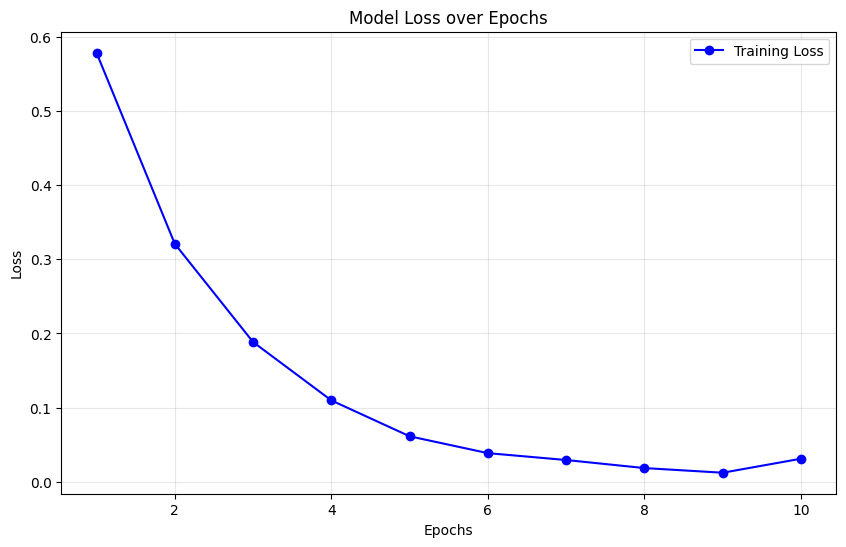

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_values, marker='o', color='blue', label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss over Epochs")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Validation Accuracy: 91.50%


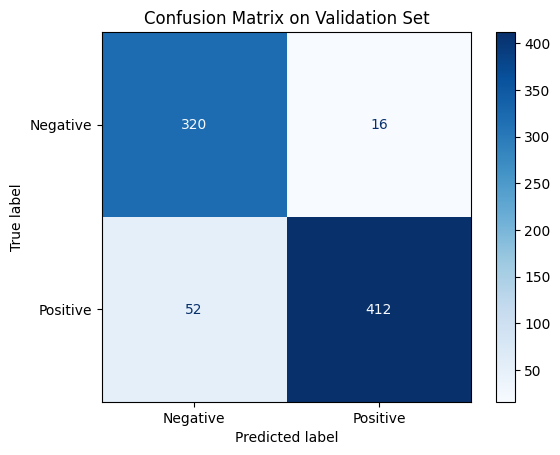

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Prepare validation data
val_inputs = [preprocess_text(text) for text in val_texts]
val_input_ids = torch.cat([x["input_ids"] for x in val_inputs]).to(device)
val_attention_mask = torch.cat([x["attention_mask"] for x in val_inputs]).to(device)
val_labels = val_labels.to(device)

val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Evaluate
classifier.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        b_input_ids, b_attention_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_attention_mask = b_attention_mask.to(device)
        b_labels = b_labels.to(device)

        outputs = classifier(input_ids=b_input_ids, attention_mask=b_attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(cmap="Blues")
plt.title("Confusion Matrix on Validation Set")
plt.show()